# TP Final TDA2

## Importaciones

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import random

from social_networks_utils_main import embeddings
from social_networks_utils_main import modelos
from social_networks_utils_main import metricas
from social_networks_utils_main.motifs import calculos
from social_networks_utils_main.motifs import graficos
from social_networks_utils_main.motifs import load
from social_networks_utils_main import homofilia

para ejecutar graphrole
pip install graphrole
ejecutar en python 3.9

In [2]:
from graphrole import RecursiveFeatureExtractor, RoleExtractor

falla en grafo aleatorio

In [3]:
import time
from social_networks_utils_main import logger
LOG = logger.Logger(logger.LogLevel.INFO)

def motif_grafo_eleatorios_b(grafo,n_motifs, iters=100):
    """
    La funcion calcula baselines para luego hacer comparaciones de motifs
    :param generador_baseline: Una función sin parámetros (supplier) que devuelve un modelo
    aleatorizado (ver el módulo modelos.py)
    :param conjuntos_motifs: Conjuntos de motifs a calcular las metrias. Se debe reibir una
    lista de listas: [ [MOTIFS_2_VERTICES], [MOTIFS_3_VERTICES], ... ], dado que el calculo
    para cada motif se hace en funcion de la cantidad de nodos, como indica en #calcular_motifs_en_paralelo
    :param iters: cantidad de iteraciones a realizar
    :return: los promedios y desvios estándar de cada motif
    """
    conteos = []
    t = time.time()
    for i in range(iters):
        LOG.info("Iteracion {}".format(i + 1) + (("; anterior: {:.2f} segs".format(time.time() - t)) if i > 0 else ""))
        t = time.time()
        g = modelos.configuration_model(metricas.distribucion_grados(grafo))
        LOG.debug("Grafo generado, vamos por motifs")
        conteos.append(calculos.calcular_motifs(g, n_motifs))
        LOG.debug(conteos[-1])

    valores = np.array(conteos)
    promedios = np.mean(valores, axis=0)
    stds = np.std(valores, axis=0)
    return promedios, stds

## Dataset

In [4]:
fronteras_reales = pd.read_csv('fronteras_terrestres_del_mundo.csv')
fronteras_reales

,País o territorio(Territorios sin soberanía plena en cursiva),Países o territorios vecinos(Territorios sin soberanía plena en cursiva)
0,China,Afganistán
1,China,Bután
2,China,Birmania
3,China,Corea del Norte
4,China,India
...,...,...
636,Dinamarca,Alemania
637,Catar,Arabia Saudita
638,San Marino,Italia
639,Mónaco,Francia


In [5]:
fronteras_TEG = pd.read_csv('paisesFronteraTeg.csv')
fronteras_TEG

,Pais,frontera,tipo
0,Canada,Newfoundland (island)|Terranova,terrestre
1,Canada,New York (state)|New York,terrestre
2,Canada,Oregon,terrestre
3,Canada,Yukon,terrestre
4,Yukon,Alaska,terrestre
...,...,...,...
84,Madagascar,Zaire,marina
85,Zaire,South Africa,terrestre
86,Sumatra,Australia,marina
87,Borneo,Australia,marina


In [6]:
paises_TEG = pd.read_csv('paisesTEG.csv')
paises_TEG

,Pais,Continente,Categoria
0,Canada,North America,canon
1,Yukon,North America,globo
2,Alaska,North America,barco
3,Greenland,North America,globo
4,Oregon,North America,canon
5,California,North America,canon
6,Mexico,North America,canon
7,New York (state)|New York,North America,barco
8,Newfoundland (island)|Terranova,North America,canon
9,Labrador,North America,canon


## Transcripcion a grafos

### fronteras reales

En el data set de fronteras reales solo se tienen e cuenta las fronteras terrestres.

In [7]:
mundo_real = nx.Graph()
for fila in fronteras_reales.iterrows():
    territorio1 = fila[1]['País o territorio(Territorios sin soberanía plena en cursiva)']
    territorio2 = fila[1]['Países o territorios vecinos(Territorios sin soberanía plena en cursiva)']
    if not mundo_real.has_node(territorio1):
        mundo_real.add_node(territorio1)
    if not mundo_real.has_node(territorio2):
        # existen mas territorios en los paises vecinos ya que no todos se repiten
        mundo_real.add_node(territorio2)
    if mundo_real.has_edge(territorio2, territorio1):
        # evita los repetidos
        continue
    mundo_real.add_edge(territorio1, territorio2)

print(mundo_real.number_of_nodes())
print(mundo_real.number_of_edges())

188
349


### datos TEG

In [8]:
mundo_TEG = nx.Graph()
for fila_de_datos in paises_TEG.iterrows():
    mundo_TEG.add_node(fila_de_datos[1]['Pais'], continente=fila_de_datos[1]['Continente'], categoria=fila_de_datos[1]['Categoria'])
mundo_TEG.number_of_nodes()

50

In [9]:
for fila in fronteras_TEG.iterrows():
    territorio1 = fila[1]['Pais']
    territorio2 = fila[1]['frontera']
    tipo = fila[1]['tipo']
    mundo_TEG.add_edge(territorio1, territorio2, tipo=tipo)
mundo_TEG.number_of_edges()

89

## Grafos aleatorios

In [30]:
# cantidades que mas se hacemejan al TEG
cantidad_de_nodos = 50
cantidad_de_aristas = 90

def generar_grafo_erdy(alpha = 0.5, rango_de_error = 0.05, iteraciones_max = 20):
    for i in range(iteraciones_max):
        grafo_erdy = modelos.erdos_renyi(cantidad_de_nodos, cantidad_de_aristas/(alpha * cantidad_de_nodos))
        if grafo_erdy.number_of_edges() > cantidad_de_aristas * (1 + rango_de_error):
            continue
        if grafo_erdy.number_of_edges() < cantidad_de_aristas * (1 - rango_de_error):
            continue
        return grafo_erdy
    print("falla al crear grafo")
    return grafo_erdy

def generar_grafo_pot(alpha = 1, rango_de_error = 0.05, iteraciones_max = 20):
    for i in range(iteraciones_max):
        grafo_pot = modelos.preferential_attachment(False, 2, cantidad_de_nodos, cantidad_de_aristas/ (alpha * cantidad_de_nodos))
        if grafo_pot.number_of_edges() > cantidad_de_aristas * (1 + rango_de_error):
            continue
        if grafo_pot.number_of_edges() < cantidad_de_aristas * (1 - rango_de_error):
            continue
        return grafo_pot
    print("falla al crear grafo")
    return grafo_pot

In [31]:
grafo_erdy = generar_grafo_erdy()
grafo_erdy.number_of_nodes(), grafo_erdy.number_of_edges()

(50, 90)

In [39]:
grafo_pot = generar_grafo_pot(alpha=0.75)
grafo_pot.number_of_nodes(), grafo_pot.number_of_edges()

(50, 93)

## Comparaciones

In [40]:
def distribucion_de_distancia(grafo):
    excentricidad = nx.eccentricity(grafo)
    return excentricidad

def distancia_media(excentricidad_del_grafo):
    nodos = excentricidad_del_grafo.keys()
    distancia_media = 0
    for nodo in nodos:
        distancia_media += excentricidad_del_grafo[nodo]
    return distancia_media / len(excentricidad_del_grafo)

def datos_varios(grafo, imprimir = False):
    diametro = nx.diameter(grafo)
    clustering = metricas.clustering(grafo)
    grado_prom = metricas.grado_promedio(grafo)
    distribucion_distancias = distribucion_de_distancia(grafo)
    distancia = distancia_media(distribucion_distancias)
    if imprimir:
        print("nodos: ", grafo.number_of_nodes())
        print("aristas: ", grafo.number_of_edges())
        print("clustering: ", clustering)
        print("diametro: ", diametro)
        print("grado promedio: ", grado_prom)
        nx.draw_networkx(grafo,node_size = 10,with_labels=False,alpha=0.75)
    return grado_prom, metricas.distribucion_grados(grafo), diametro, clustering, distancia, distribucion_distancias

nodos:  50
aristas:  89
clustering:  ([0, 0.0, 0.49999999999999994, 0.35555555555555546, 0.35, 0.35714285714285715, 0.28888888888888886, 0.3333333333333333, 0.2857142857142857], 0.37638095238095237)
diametro:  9
grado promedio:  3.56


(3.56,
 array([ 0,  1, 12, 15, 10,  7,  3,  1,  1]),
 9,
 ([0,
   0.0,
   0.49999999999999994,
   0.35555555555555546,
   0.35,
   0.35714285714285715,
   0.28888888888888886,
   0.3333333333333333,
   0.2857142857142857],
  0.37638095238095237))

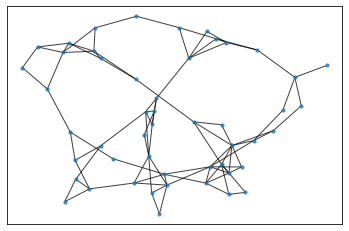

In [42]:
datos_varios(mundo_TEG, True)